In [151]:
# check nans for /shares/gcp/integration/float32/sectoral_ir_damages/mortality_epa_vsl/impacts-darwin-montecarlo-damages-vsl_popavg-histclim-delta.zarr
# maps comparing mortality damage functions


In [153]:
import xarray as xr
from dscim.diagnostics.damage_function import damage_function
import os

import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from dscim.utils.utils import compute_damages
import logging

logger = logging.getLogger(__name__)

username = os.getenv("USER")

In [166]:
sectors=['mortality_vsl_popavg', 'mortality_vsl_ir', "mortality"]
years=[2100,2200,2300]
recipes = ['adding_up']
pulse_year=2020
xlims=[(0,2), (0,20), (0,8)]

In [155]:


def damage_function_overlay(
    sector_list,
    # sector_path_list,
    discounting,
    eta,
    rho,
    year=2097,
    hue_vars="ssp",
    recipe="adding_up",
    scale=10**12,
    x_lim=(-np.inf, np.inf),
    y_lim=(-np.inf, np.inf),
    x_var="anomaly",
    legacy=None,
    save_path=None,
    subset_dict=None,
    scatter=True,
    attributes=True,
):


    points, fit, attrs = {}, {}, {}

    points, fit = {}, {}
    for sector in sector_list:

        # get relevant files
        points_file = pd.read_csv(
            f"/mnt/CIL_integration/menu_results_AR6_epa/{sector}/{pulse_year}/unmasked/{recipe}_{discounting}_eta{eta}_rho{rho}_damage_function_points.csv"
        ).reset_index()

        fit_file = xr.open_dataset(
            f"/mnt/CIL_integration/menu_results_AR6_epa/{sector}/{pulse_year}/unmasked/{recipe}_{discounting}_eta{eta}_rho{rho}_damage_function_fit.nc4"
        )

        # subset
        if subset_dict != None:
            for col, val in subset_dict.items():
                points_file = points_file.loc[points_file[col].isin(val)]
            fit_file = fit_file.sel(subset_dict)

        points[sector] = points_file.reset_index()
        fit[sector] = fit_file.to_dataframe().reset_index()

        # save attributes to label plot
        attrs[
            sector
        ] = f"""
            eta: {fit_file.attrs['eta']}, rho: {fit_file.attrs['rho']},
        """

        # subset years
        points[sector] = points[sector].loc[
            (points[sector].year >= year - 2) & (points[sector].year <= year + 2)
        ]
        fit[sector] = fit[sector].loc[fit[sector].year == year]

        # scale damage points and betas
        points[sector]["damages_scaled"] = points[sector][
            "damages"
            #             f"global_damages_{discounting}"
        ].apply(lambda x: x / scale)
        fit[sector]["y_hat_scaled"] = fit[sector]["y_hat"].apply(lambda x: x / scale)

        fit[sector]["hue"] = reduce(
            lambda a, b: a.str.cat(b, sep=","),
            [fit[sector][i].astype(str) for i in hue_vars],
        )
        points[sector]["hue"] = reduce(
            lambda a, b: a.str.cat(b, sep=","),
            [points[sector][i].astype(str) for i in hue_vars],
        )

    # grab legacy function if passed
    if legacy != None:
        fit["legacy"] = get_legacy(sector, filepath=legacy[0], scale=legacy[1])
        fit["legacy"] = fit["legacy"].loc[fit["legacy"].year == year]
        fit["legacy"]["y_hat_scaled"] = fit["legacy"]["y_hat"].apply(
            lambda x: x / scale
        )

    sns.set_style("darkgrid")

    fig, ax = plt.subplots(
        1, len(sectors), figsize=(15, 10), sharex=True, sharey=True, squeeze=False
    )

    plt.subplots_adjust(wspace=0, hspace=0, top=0.90)

    palette = "tab10" if discounting == "constant_model_collapsed" else "tab20"

    for i, sector in enumerate(sector_list):

        print(f"{sector} : # of points is {len(points[sector])}")

        if scatter == True:

            sns.scatterplot(
                data=points[sector]
                .loc[
                    (points[sector].damages_scaled >= y_lim[0])
                    & (points[sector].damages_scaled <= y_lim[1])
                    & (points[sector][x_var] >= x_lim[0])
                    & (points[sector][x_var] <= x_lim[1])
                ]
                .sort_values("hue"),
                x=x_var,
                y=f"damages_scaled",
                hue="hue",
                palette=palette,
                s=6,
                ax=ax[0][i],
                edgecolor="face",
            )

        sns.lineplot(
            data=(
                fit[sector]
                .loc[
                    (fit[sector][x_var] >= x_lim[0]) & (fit[sector][x_var] <= x_lim[1])
                ]
                .sort_values("hue")
            ),
            x=x_var,
            y="y_hat_scaled",
            hue="hue",
            palette=palette,
            ax=ax[0][i],
        )

        if legacy != None:

            sns.lineplot(
                data=fit["legacy"],
                x=x_var,
                y="y_hat_scaled",
                color="grey",
                linestyle="dotted",
                ax=ax[0][i],
            )

        ax[0][i].set_xlabel(x_var)
        ax[0][i].set_title(f"sector: {sector}")
        if attributes == True:
            ax[0][0].annotate(
                attrs[sector], (0.0, -0.1), xycoords="axes fraction", fontsize=6
            )

    ltext = "\n paper damage function = grey dotted" if legacy != None else ""
    fig.suptitle(
        f"{recipe}: {discounting} discounting \n Damage functions in {year} {ltext}"
    )

    ax[0][0].set_ylabel(f'Damages in {"{:.0e}".format(scale)} 2019 USD')

    if save_path != None:

        os.makedirs(save_path, exist_ok=True)
        plt.savefig(f"{save_path}/{sector}_{discounting}_{year}_damage_function.pdf")

    return fig


In [156]:
# for recipe in recipes:
#     for year in years:
#         for x_lim in xlims:
#             damage_function_overlay(
#                 sector_list=sectors,
#                 # sector_path_list = [f"/mnt/CIL_integration/menu_results_AR6_epa/{sectors[0]}/{pulse_year}/unmasked",
#                 #                     f"/mnt/CIL_integration/menu_results_AR6_epa/{sectors[1]}/{pulse_year}/unmasked"],
#                 discounting = 'euler_ramsey', 
#                 recipe =  "adding_up", 
#                 hue_vars = ['ssp', 'model'],
#                 x_var = "anomaly",
#                 year = year,    
#                 scatter=True,
#                 x_lim=x_lim,
#                 eta=2.0,
#                 rho=0.0,
#                 subset_dict = {'ssp': ["SSP3"], 'model':['IIASA GDP']},
#                 save_path=f'/mnt/CIL_integration/plots/mortality_damage_function_comparison/{x_lim[0]}_{x_lim[1]}C')

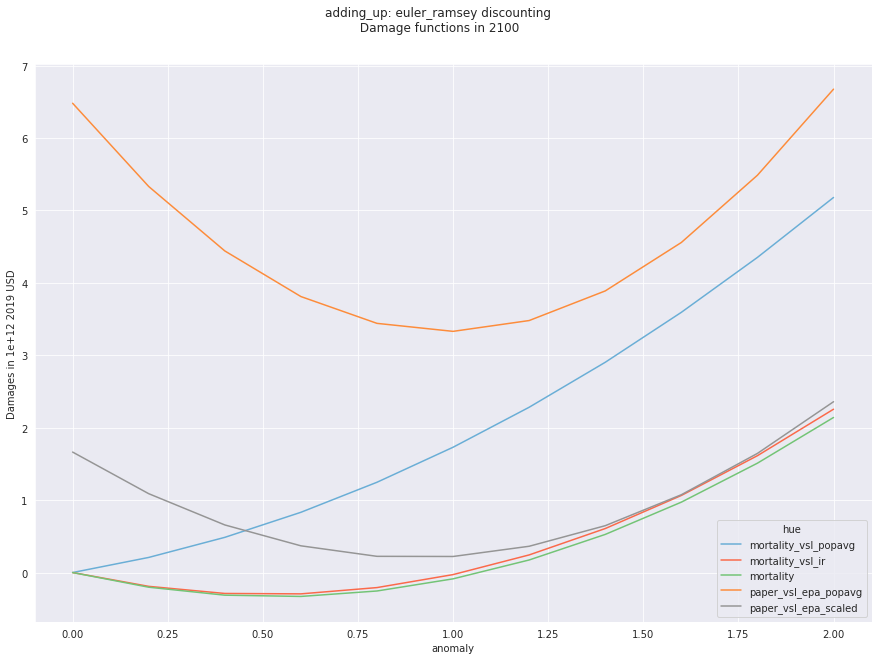

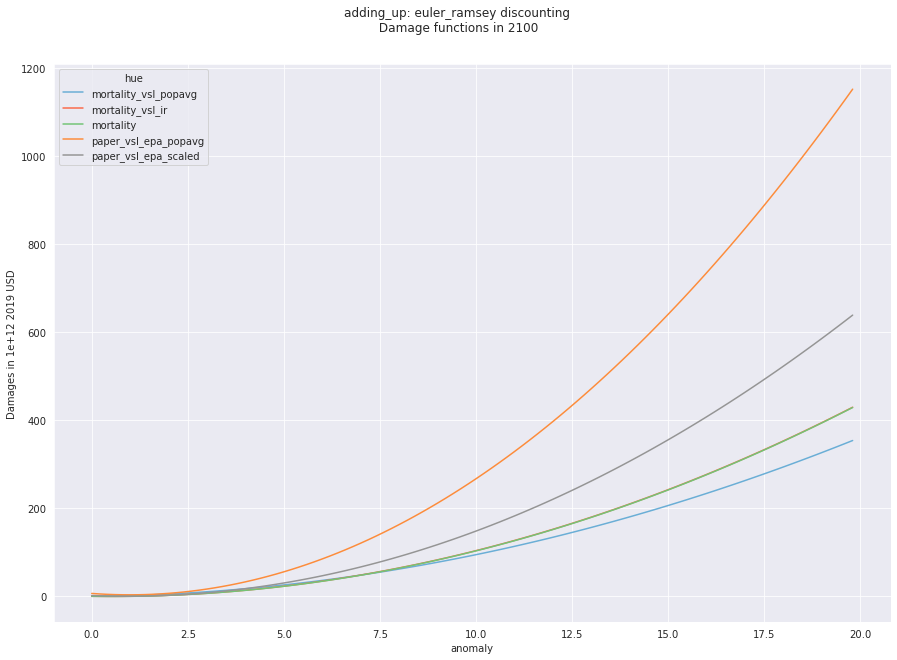

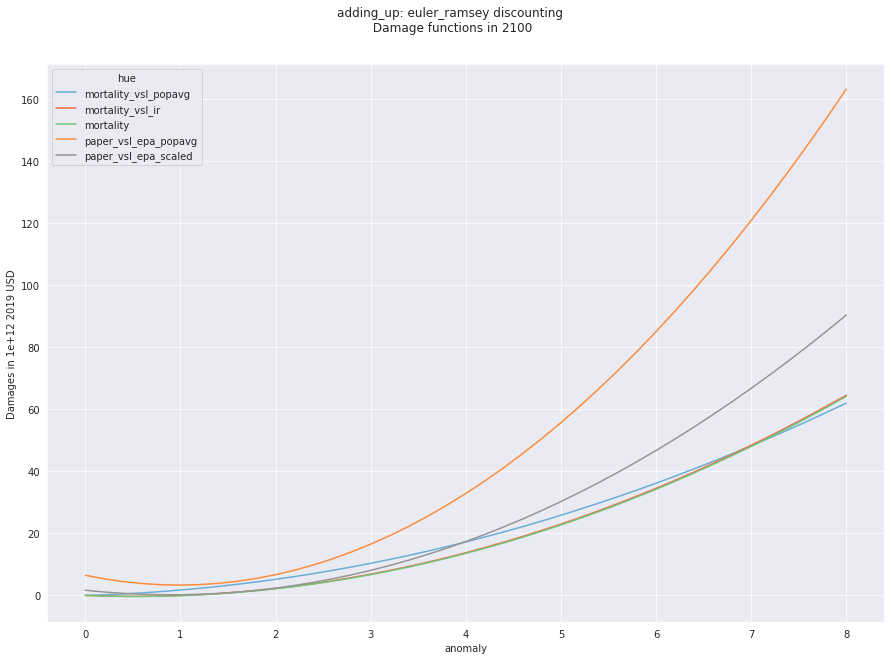

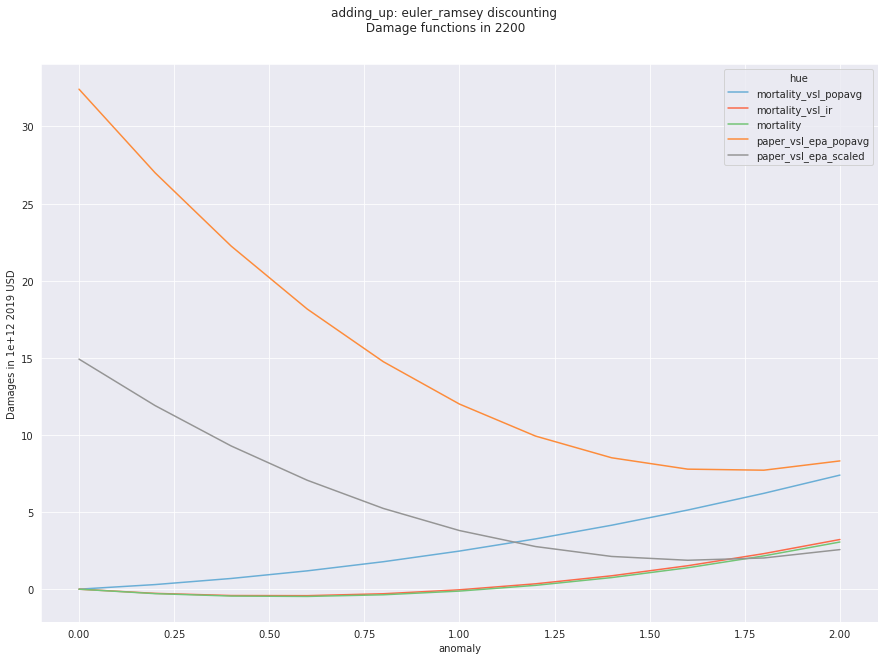

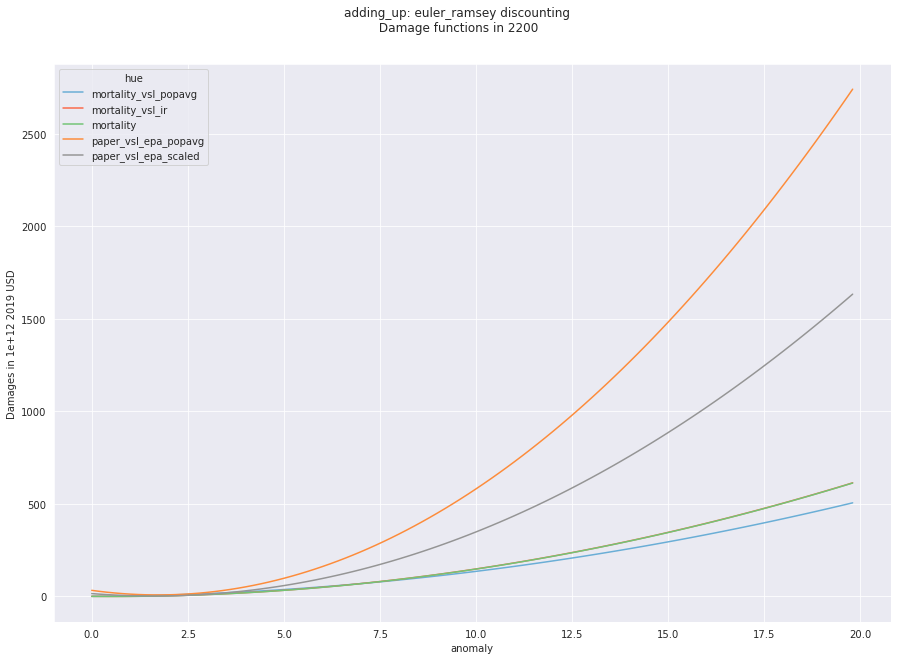

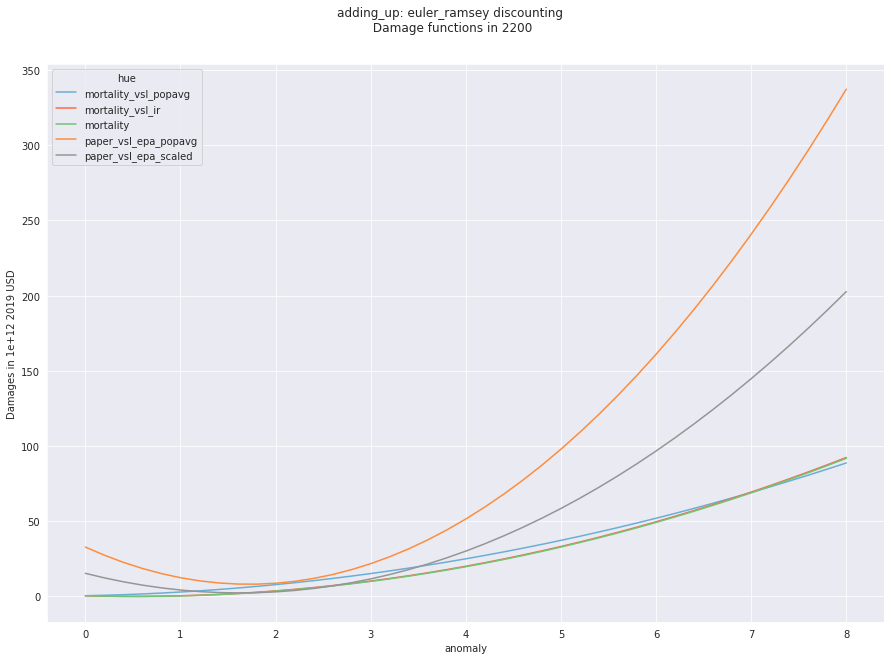

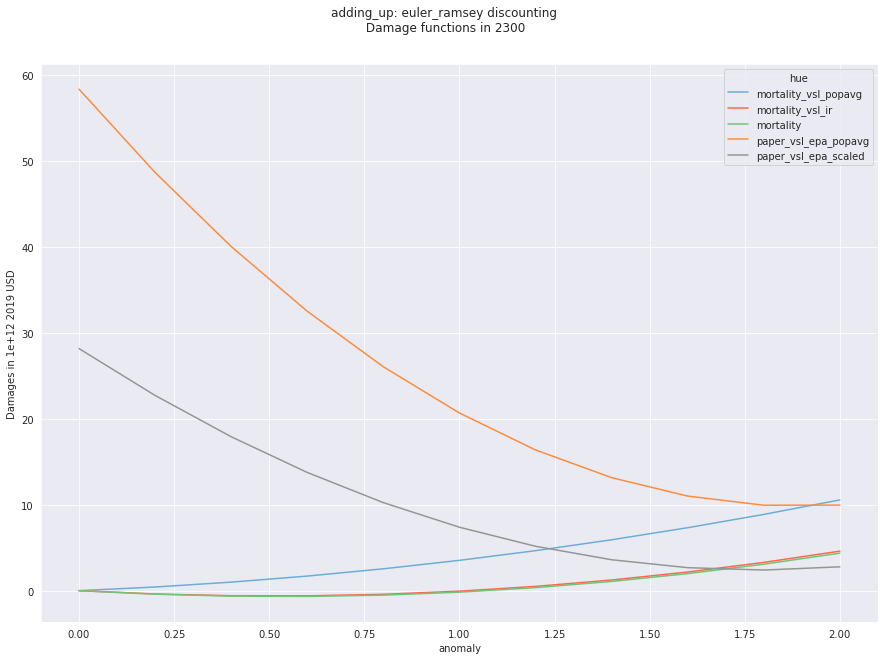

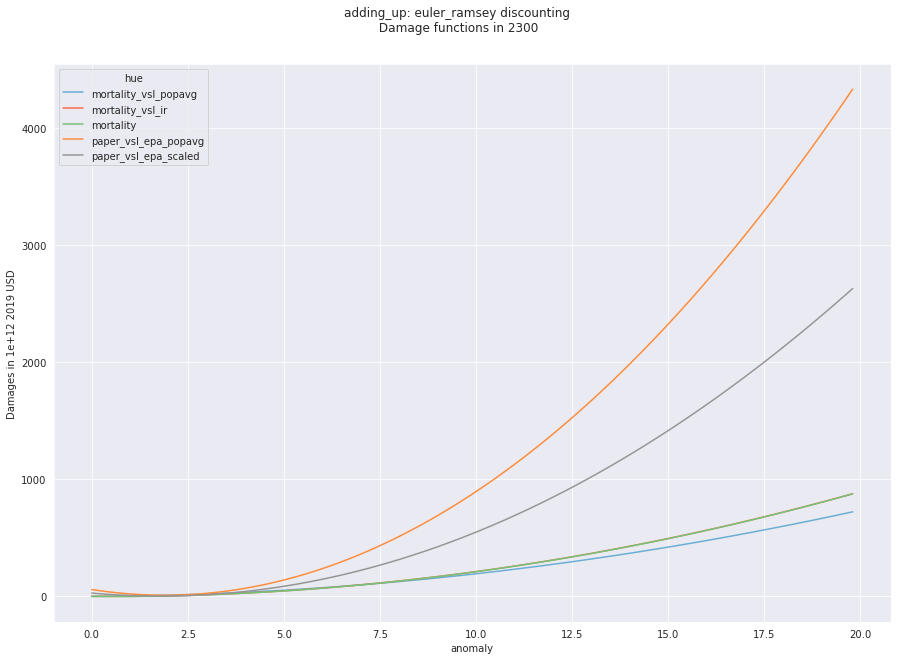

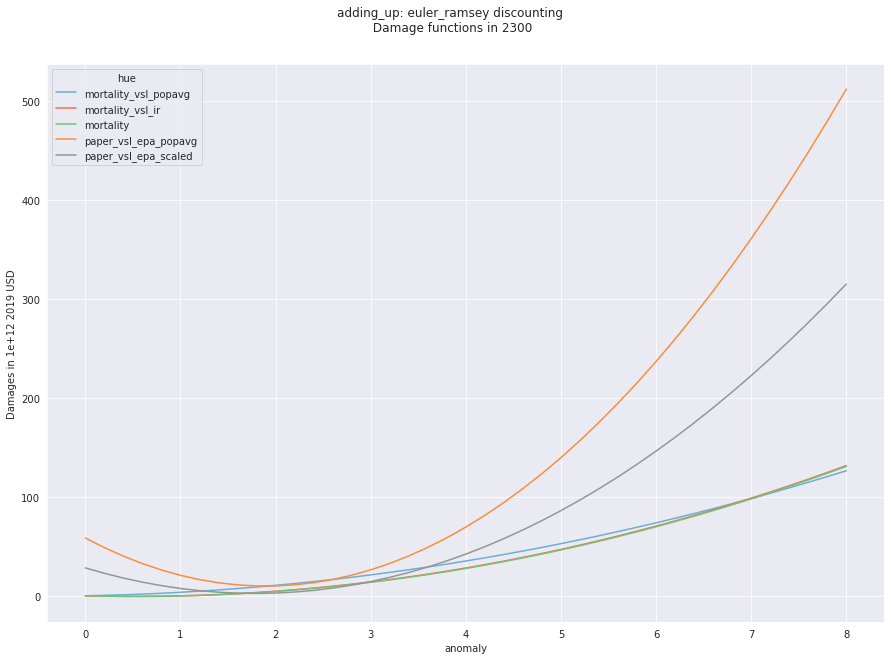

In [167]:
def damage_function_overlay(
    sector_list,
    # sector_path_list,
    discounting,
    eta,
    rho,
    year=2097,
    hue_vars="ssp",
    recipe="adding_up",
    scale=10**12,
    x_lim=(-np.inf, np.inf),
    y_lim=(-np.inf, np.inf),
    x_var="anomaly",
    legacy=None,
    save_path=None,
    subset_dict=None,
    scatter=False,
    attributes=False,
):


    points, fit, attrs = {}, {}, {}

#     coefficients from mortality paper
    paper_df = xr.open_dataset("/mnt/CIL_integration/plots/mortality_damage_function_comparison/damage_function_fit_curves_SSP3_new_MC.nc4") / 1000
    
    points, fit = {}, {}
    for sector in sector_list:

        # get relevant files
        # points_file = pd.read_csv(
        #     f"/mnt/CIL_integration/menu_results_AR6_epa/{sector}/{pulse_year}/unmasked/{recipe}_{discounting}_eta{eta}_rho{rho}_damage_function_points.csv"
        # ).reset_index()

        fit_file = xr.open_dataset(
            f"/mnt/CIL_integration/menu_results_AR6_epa/{sector}/{pulse_year}/unmasked/{recipe}_{discounting}_eta{eta}_rho{rho}_damage_function_fit.nc4"
        )

        # subset
        if subset_dict != None:
            # for col, val in subset_dict.items():
            #     points_file = points_file.loc[points_file[col].isin(val)]
            fit_file = fit_file.sel(subset_dict)

        # points[sector] = points_file.reset_index()
        fit[sector] = fit_file.to_dataframe().reset_index()

        # save attributes to label plot
        attrs[
            sector
        ] = f"""
            eta: {fit_file.attrs['eta']}, rho: {fit_file.attrs['rho']},
        """

        # subset years
        # points[sector] = points[sector].loc[
        #     (points[sector].year >= year - 2) & (points[sector].year <= year + 2)
        # ]
        fit[sector] = fit[sector].loc[fit[sector].year == year]

        # scale damage points and betas
        # points[sector]["damages_scaled"] = points[sector][
        #     "damages"
        #     #             f"global_damages_{discounting}"
        # ].apply(lambda x: x / scale)
        fit[sector]["y_hat_scaled"] = fit[sector]["y_hat"].apply(lambda x: x / scale)

        fit[sector]["hue"] = sector
        # reduce(
        #     lambda a, b: a.str.cat(b, sep=","),
        #     [fit[sector][i].astype(str) for i in hue_vars],
        # )
        # points[sector]["hue"] = sector
        # reduce(
        #     lambda a, b: a.str.cat(b, sep=","),
        #     [points[sector][i].astype(str) for i in hue_vars],
        # )

    fit['paper_vsl_epa_popavg'] = paper_df.sel(age_adjustment = "vsl", vsl_value = "epa", heterogeneity = "popavg", drop = True)[['anomaly','y_hat']].to_dataframe().reset_index()
    fit['paper_vsl_epa_scaled'] = paper_df.sel(age_adjustment = "vsl", vsl_value = "epa", heterogeneity = "scaled", drop = True)[['anomaly','y_hat']].to_dataframe().reset_index()
    
    fit['paper_vsl_epa_popavg'] = fit['paper_vsl_epa_popavg'].loc[fit['paper_vsl_epa_popavg'].year == year]
    fit['paper_vsl_epa_scaled'] = fit['paper_vsl_epa_scaled'].loc[fit['paper_vsl_epa_scaled'].year == year]
    fit['paper_vsl_epa_popavg']['hue'] =  'paper_vsl_epa_popavg'
    fit['paper_vsl_epa_scaled']['hue'] =  'paper_vsl_epa_scaled'
    fit['paper_vsl_epa_popavg']['y_hat_scaled'] =  fit['paper_vsl_epa_popavg']['y_hat']
    fit['paper_vsl_epa_scaled']['y_hat_scaled'] =  fit['paper_vsl_epa_scaled']['y_hat']
    
    # grab legacy function if passed
    if legacy != None:
        fit["legacy"] = get_legacy(sector, filepath=legacy[0], scale=legacy[1])
        fit["legacy"] = fit["legacy"].loc[fit["legacy"].year == year]
        fit["legacy"]["y_hat_scaled"] = fit["legacy"]["y_hat"].apply(
            lambda x: x / scale
        )

    sns.set_style("darkgrid")

    fig, ax = plt.subplots(
        1, 1, figsize=(15, 10), sharex=True, sharey=True, squeeze=False
    )

    plt.subplots_adjust(wspace=0, hspace=0, top=0.90)

    palette = "tab10" if discounting == "constant_model_collapsed" else "tab20"

    colors = ['Blues','Reds','Greens', "Oranges", "Greys"]
    sector_list = sector_list + ['paper_vsl_epa_popavg', 'paper_vsl_epa_scaled']
    for i, sector in enumerate(sector_list):

        # print(f"{sector} : # of points is {len(points[sector])}")

#         if scatter == True:

#             sns.scatterplot(
#                 data=points[sector]
#                 .loc[
#                     (points[sector].damages_scaled >= y_lim[0])
#                     & (points[sector].damages_scaled <= y_lim[1])
#                     & (points[sector][x_var] >= x_lim[0])
#                     & (points[sector][x_var] <= x_lim[1])
#                 ]
#                 .sort_values("hue"),
#                 x=x_var,
#                 y=f"damages_scaled",
#                 hue="hue",
#                 palette = colors[i],
#                 s=6,
#                 ax=ax[0][0],
#                 edgecolor="face",
#             )

        sns.lineplot(
            data=(
                fit[sector]
                .loc[
                    (fit[sector][x_var] >= x_lim[0]) & (fit[sector][x_var] <= x_lim[1])
                ]
                .sort_values("hue")
            ),
            x=x_var,
            palette = colors[i],
            y="y_hat_scaled",
            hue="hue",
            ax=ax[0][0],
        )

        if legacy != None:

            sns.lineplot(
                data=fit["legacy"],
                x=x_var,
                y="y_hat_scaled",
                color="grey",
                linestyle="dotted",
                ax=ax[0][i],
            )

        ax[0][0].set_xlabel(x_var)
        # ax[0][0].set_title(f"recipe: {recipe}")
        if attributes == True:
            ax[0][0].annotate(
                attrs[sector], (0.0, -0.1), xycoords="axes fraction", fontsize=6
            )

    ltext = "\n paper damage function = grey dotted" if legacy != None else ""
    fig.suptitle(
        f"{recipe}: {discounting} discounting \n Damage functions in {year} {ltext}"
    )

    ax[0][0].set_ylabel(f'Damages in {"{:.0e}".format(scale)} 2019 USD')

    if save_path != None:

        os.makedirs(save_path, exist_ok=True)
        plt.savefig(f"{save_path}/{recipe}_{discounting}_{year}_damage_function.pdf")

    return fig




for recipe in recipes:
    for year in years:
        for x_lim in xlims:
            damage_function_overlay(
                sector_list=sectors,
                # sector_path_list = [f"/mnt/CIL_integration/menu_results_AR6_epa/{sectors[0]}/{pulse_year}/unmasked",
                #                     f"/mnt/CIL_integration/menu_results_AR6_epa/{sectors[1]}/{pulse_year}/unmasked"],
                discounting = 'euler_ramsey', 
                recipe =  "adding_up", 
                hue_vars = ['ssp', 'model'],
                x_var = "anomaly",
                year = year,    
                scatter=False,
                x_lim=x_lim,
                eta=2.0,
                rho=0.0,
                subset_dict = {'ssp': ["SSP3"], 'model':['IIASA GDP']},
                save_path=f'/mnt/CIL_integration/plots/mortality_damage_function_comparison/{x_lim[0]}_{x_lim[1]}C')

In [163]:
d = xr.open_dataset("/mnt/CIL_integration/menu_results_AR6_epa/mortality/2020/unmasked/adding_up_constant_eta2.0_rho0.0_damage_function_fit.nc4")




In [164]:
d

<xarray.Dataset>
Dimensions:        (discount_type: 1, ssp: 3, model: 2, anomaly: 100, year: 281)
Coordinates:
  * discount_type  (discount_type) object 'constant'
  * ssp            (ssp) object 'SSP2' 'SSP3' 'SSP4'
  * model          (model) object 'IIASA GDP' 'OECD Env-Growth'
  * anomaly        (anomaly) float64 0.0 0.2 0.4 0.6 0.8 ... 19.2 19.4 19.6 19.8
  * year           (year) int64 2020 2021 2022 2023 2024 ... 2297 2298 2299 2300
Data variables:
    y_hat          (discount_type, ssp, model, anomaly, year) float64 ...
Attributes: (12/51)
    sector_path:                    /shares/gcp/integration/float32/input_dat...
    save_path:                      /mnt/CIL_integration/menu_results_AR6_epa...
    gdppc_bottom_code:              39.39265060424805
    subset_dict:                    {'ssp': ['SSP2', 'SSP3', 'SSP4']}
    econ_vars:                      <dscim.menu.simple_storage.EconVars objec...
    climate:                        <dscim.menu.simple_storage.Climate object...
    ...                             ...
    base_period:                    [2001, 2010]
    ecs_mask_path:                  /shares/gcp/integration/float32/dscim_inp...
    ecs_mask_name:                  None
    path:                           /shares/gcp/integration/float32/dscim_inp...
    machine:                        sacagawea
    commit:                         b'v1.0.2-87-gb669ee48'